In [42]:
import torch
import pandas as pd
from copy import deepcopy
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score
import math
import time

torch.manual_seed(1)

# 1 Loading data
Getting data from files, and converting the time values to seconds instead of 0:00:00.00

In [43]:
def grabDataThigh(filename : str, header = 1,):
    types = defaultdict(float, A=str)
    df = pd.read_csv(filename,header=header,dtype=types)
    dfThigh = df.loc[df["type"]=="t"]
    return dfThigh

def fixTimeData(df : pd.DataFrame):
    data = deepcopy(df)
    datadict = data.to_dict("list")
    timeValues = []
    x = datadict["time"]
    for i in range(len(x)):
        xValues = re.findall(r'[0-9.]+',x[i])
        tmpTime = 360*float(xValues[0])
        tmpTime = tmpTime + 60*float(xValues[1])
        tmpTime = tmpTime + float(xValues[2])
        timeValues.append(tmpTime)
    datadict["time"] = timeValues
    
    return datadict

def fixData(data : dict, normalize, Time : bool, FSR : bool, Grav : bool, Gyro : bool, Quat : bool, LiAcc :bool, Classification : bool):
    '''
    For normalization, set normalize = "minmax" for min-max normalization, or normalize = "z-score" for standardization 
    '''

    DataList = list(data.items())
    popList = []
    for i in range(len(DataList)):
        if "time" in DataList[i][0] and not Time:
            popList.append(i)
        if "FSR" in DataList[i][0] and not FSR:
            popList.append(i)
        if "Grav" in DataList[i][0] and not Grav:
            popList.append(i)
        if "Gyro" in DataList[i][0] and not Gyro:
            popList.append(i)
        if "Quat" in DataList[i][0] and not Quat:
            popList.append(i)
        if "LiAcc" in DataList[i][0] and not LiAcc:
            popList.append(i)
        if "Cal" in DataList[i][0] and not "Gyro" in DataList[i][0]:
            popList.append(i)
        if "GyroCal" in DataList[i][0]:
            popList.append(i)
        if "Class" in DataList[i][0] and not Classification:
            popList.append(i)
    for i in range(len(popList)):
        DataList.pop(popList[i]-i)
    if normalize == "minmax":
        newDict = {}
        for key, column in DataList:
            if key != "class":
                data = np.array(column)
                column = list((data - min(data)) / (max(data) - min(data)))
                newDict[key] = column
            else:
                newDict[key] = column
        return newDict
    if normalize == "z-score":
        newDict = {}
        for key, column in DataList:
            if key != "class":
                data = np.array(column)
                column = list((data - data.mean()) / data.std())
                newDict[key] = column
            else:
                newDict[key] = column
        return newDict
    return dict(DataList)

def processFSR(data : dict, FSR : bool, FSRsum : bool, FSRavg : bool):
    dataDict = {}
    df = pd.DataFrame(data)
    additional = pd.DataFrame()
    FSRSum = df.sum(axis=1)
    FSRSum = pd.DataFrame(FSRSum)
    additional["FSRSum"] = FSRSum
    FSRAvg = FSRSum.div(len(df.columns))
    FSRAvg = pd.DataFrame(FSRAvg)
    additional["FSRAvg"] = FSRAvg
    if FSR:
        if FSRsum:
            df["FSRsum"] = additional["FSRSum"]
        if FSRavg:
            df["FSRavg"] = additional["FSRAvg"]
        data = df.to_dict("list")
    elif FSRsum and FSRavg:
        data = additional.to_dict("list")
    elif FSRsum:
        df = additional.to_dict("list")
        dataDict["FSRSum"] = df["FSRSum"]
        return dataDict
    elif FSRavg:
        df = additional.to_dict("list")
        dataDict["FSRAvg"] = df["FSRAvg"]
        return dataDict
    return data

def dictExtension(ListOfData : list):
    DataList = list(ListOfData[0].items())
    for i in range(1,len(ListOfData)):
        for j in range(len(DataList)):
            listData = list(ListOfData[i].items())
            tmpList = listData[j][1]
            DataList[j][1].extend(tmpList)
    dataDict = dict(DataList)
    return dataDict


def plot3FSRComparisons(dataList : list):
    fig, ax = plt.subplots(1,3,sharey=True,figsize=(17,5))
    nameList = ["Walk", "Upstairs", "Downstairs"]
    color_list = [
    "#000000",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion (not pure red)
    "#FF84C8",  # Reddish Purple
    "#999999",  # Grey
    ]
    tmpCount = 0
    for i in range(len(dataList)):
        tmpDictList = list(dataList[i].items())
        if tmpCount == 0:
            x = list(k-tmpDictList[0][1][0] for k in tmpDictList[0][1]) 
            print(x)
            for j in range(1,len(tmpDictList)):
                if "FSR" in tmpDictList[j][0]:
                    ax[i].plot(x[:200],tmpDictList[j][1][:200],label=f"FSR {j}",color=color_list[j-1],linewidth=3)
                    ax[i].set_title(nameList[i])
                    ax[i].legend()
        if tmpCount != 0:
            print(x)
            for j in range(0,len(tmpDictList)):
                if "FSR" in tmpDictList[j][0]:
                    ax[i].plot(x[:200],tmpDictList[j][1][:200],label=f"FSR {j-1}",color=color_list[j-2],linewidth=3)
                    ax[i].set_title(nameList[i])
                    ax[i].legend()
        tmpCount = tmpCount + 1
    ax[0].set_ylabel("FSR Measurement")
    ax[1].set_xlabel("time [s]")
    plt.show()

def checkDictForStr(data :dict):
    for j in data:
        for i in range(len(data[j])):
            if isinstance(data[j][i],str):
                data[j][i] = float(data[j][i])
    return data


[0.0, 0.004001000000000001, 0.009002, 0.013003, 0.017004000000000002, 0.023005, 0.027006, 0.032006999999999994, 0.036008, 0.041010000000000005, 0.045009999999999994, 0.049011, 0.054013000000000005, 0.05801300000000001, 0.062014, 0.067015, 0.07101600000000001, 0.076017, 0.080018, 0.08401900000000001, 0.08902, 0.093021, 0.09702200000000001, 0.102024, 0.10602400000000001, 0.111025, 0.115026, 0.12002700000000001, 0.12402800000000001, 0.12902899999999998, 0.13302999999999998, 0.137031, 0.142032, 0.146033, 0.151034, 0.15603499999999998, 0.16003599999999998, 0.164037, 0.169038, 0.173039, 0.17804, 0.18204199999999998, 0.18704199999999999, 0.191043, 0.196044, 0.200045, 0.20404599999999998, 0.20904799999999998, 0.213048, 0.21805, 0.22205, 0.227052, 0.23105199999999998, 0.23605299999999999, 0.240054, 0.24405499999999997, 0.249056, 0.253057, 0.257058, 0.26206, 0.26605999999999996, 0.271061, 0.275062, 0.280063, 0.284064, 0.289065, 0.293066, 0.29806699999999997, 0.302068, 0.306069, 0.31107, 0.315071

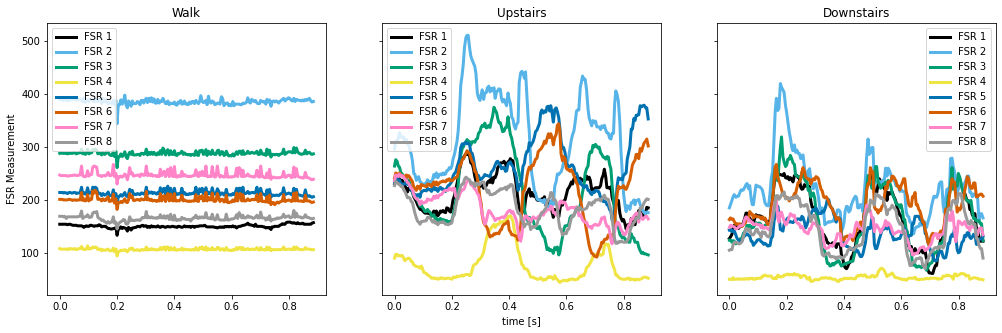

In [44]:
filename = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jonas 6 min.txt"
filename2 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jonas Upstairs.csv"
filename3 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jonas Downstairs.csv"

dfWalk = grabDataThigh(filename)
dataWalk = fixTimeData(dfWalk)
dataWalk.pop('type')
dataWalk["Class"] = list(0 for i in range(len(dataWalk["time"])))

dfUp = grabDataThigh(filename2,0)
#dataUp = fixTimeData(dfUp)
dataUp = dfUp.to_dict("list")
dataUp.pop('type')
dataUp["Class"] = list(1 for i in range(len(dataUp["time"])))

dfDown = grabDataThigh(filename3,0)
#dataDown = fixTimeData(dfDown)
dataDown = dfDown.to_dict("list")
dataDown.pop('type')
dataDown["Class"] = list(-1 for i in range(len(dataDown["time"])))

dataList = [dataWalk,dataUp,dataDown]
data = dictExtension(dataList)
data = checkDictForStr(data)
plot3FSRComparisons(dataList)

In [45]:
Time = False
FSR = True     # val: 98.89 test: 87.59%
FSRsum = False    # val: 98.89 test: 91.97%
FSRavg = False     # val: 98.89 test: 91.97%
Grav = True    # val: 78.28 test: 85
Gyro = True    # val: 98.01 test 87.53
Quat = True    # val: 98.94 test: 94.19
LiAcc = True   # val: 97.06 test: 81.22
normalize = "minmax"
Classification = False
# FSR + sum + Quat = 98.96 val 94.28 test

with open(filename) as f:
    firstline = f.readline()
    f.close()
sampleRate = re.findall(r'[0-9.]+',firstline)
print(sampleRate)

wantedTime = 0.01
timeStep = math.floor(float(sampleRate[0])/(1/wantedTime))

data = checkDictForStr(data)
data = fixData(data,normalize,Time,True, Grav,Gyro,Quat,LiAcc,Classification)
data = processFSR(data, FSR, FSRsum, FSRavg)
inputSize = len(data)
print(inputSize)
straightSize = dfWalk.shape[0]
upSize = dfUp.shape[0]
downSize = dfDown.shape[0]


['135.22252747252747']
21


# 2 Transforming data to sequence tensor
This is done so the data is able to be provided to an LSTM

In [46]:
def prepareSingleSequenceInput(dataDict):
    """
    Converts a feature-wise dictionary into an LSTM-compatible tensor.

    Parameters:
        dataDict (dict): Dictionary where each of the 26 keys maps to a list of values representing the sequence.

    Returns:
        torch.Tensor: Tensor of shape (seqLen, 1, inputSize=26)
    """
    featureNames = sorted(dataDict.keys())  # sort keys to maintain order
    seqLen = len(next(iter(dataDict.values())))
    inputSize = len(featureNames)

    # Stack features into shape: (seqLen, inputSize)
    sequence = [[dataDict[feat][t] for feat in featureNames] for t in range(seqLen)]
    # Convert to tensor and add batch dimension: (seqLen, 1, inputSize)
    tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(1)
    return tensor

sequence = prepareSingleSequenceInput(data)[::timeStep]

print(sequence.shape)

torch.Size([26209, 1, 21])


# 3 Creating an LSTM model

In [47]:

class SequenceDataset(Dataset):
    def __init__(self, fullSequence, seqLen=100):
        """
        fullSequence: tensor of shape (totalLen, inputSize)
        """
        self.seqLen = seqLen
        self.data = fullSequence
        self.samples = self.createSequences()

    def createSequences(self):
        sequences = []
        for i in range(len(self.data) - self.seqLen):
            seq = self.data[i:i+self.seqLen]
            label = self.data[i+self.seqLen]  # e.g. next step prediction
            sequences.append((seq, label))
        return sequences

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [48]:
'''if normalized:
    targetMean = sequence.mean(dim=0)
    targetStd = sequence.std(dim=0)
    normalizedSequence = (sequence - targetMean) / targetStd
    dataset = SequenceDataset(normalizedSequence,250)
else:
'''
dataset = SequenceDataset(sequence,100)
def getSlicing(lengths):
    train = []
    val = []
    test = []
    for i in lengths:
        totalSamples = i
        trainSize = int(0.7 * totalSamples)
        valSize = int(0.15 * totalSamples)
        testSize = totalSamples - trainSize - valSize
        
        train.append(trainSize)
        val.append(valSize)
        test.append(testSize)
    return train, val, test

lengths = [straightSize-34,upSize-33,downSize-33]
#dataset = dataset[0:len(dataset):timeStep]
print(f"Added together: {sum([straightSize-34,upSize-33,downSize-33])}")
print(f"True Length {len(dataset)}")

trainSizes, valSize, testSizes = getSlicing(lengths)
dataLength = [0,lengths[0],lengths[0]+lengths[1],lengths[0]+lengths[1]+lengths[2]]

trainDataset = dataset[dataLength[0]:trainSizes[0]]
valDataset = dataset[trainSizes[0]+dataLength[0]:trainSizes[0]+dataLength[0]+valSize[0]]
testDataset = dataset[trainSizes[0]+dataLength[0]+valSize[0]:dataLength[0+1]]
print(len(testDataset))
for i in range(1,3):
    trainDataset = trainDataset + dataset[dataLength[i]:trainSizes[i]]
    valDataset = valDataset + dataset[trainSizes[i]+dataLength[i]:trainSizes[i]+dataLength[i]+valSize[i]]
    testDataset = testDataset + dataset[trainSizes[i]+dataLength[i]+valSize[i]:dataLength[i+1]]
    print(len(testDataset))

totalSamples = len(dataset)
trainSize = int(0.7 * totalSamples)
valSize = int(0.15 * totalSamples)
testSize = totalSamples - trainSize - valSize

trainDataset1 = dataset[:trainSize]
valDataset1 = dataset[trainSize:trainSize + valSize]
testDataset1 = dataset[trainSize + valSize:]

print(len(trainDataset),len(valDataset),len(testDataset))
print(len(trainDataset1),len(valDataset1),len(testDataset1))

if len(dataset) == len(trainDataset)+len(valDataset)+len(testDataset):
    print("Same length")
    print(len(dataset))
else:
    print("Fix your stuff")

if timeStep == 1:
    trainDataloader = DataLoader(trainDataset, batch_size=32, shuffle=True)
    valDataloader = DataLoader(valDataset, batch_size=32)
    testDataloader = DataLoader(testDataset, batch_size=32)
else:
    trainDataloader = DataLoader(trainDataset1, batch_size=32, shuffle=True)
    valDataloader = DataLoader(valDataset1, batch_size=32)
    testDataloader = DataLoader(testDataset1, batch_size=32)

Added together: 26109
True Length 26109
3687
3833
3919
17203 3915 3919
18276 3916 3917
Fix your stuff


In [49]:
class LSTMModel(nn.Module):
    def __init__(self, inputSize=25, hiddenSize=50, numLayers=1, outputSize=25):
        super(LSTMModel, self).__init__()
        
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        
        # LSTM Layer
        self.lstm = nn.LSTM(inputSize, hiddenSize, numLayers, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hiddenSize, outputSize)

    def forward(self, x):
        # x: (batchSize, seqLen, inputSize)
        h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize).to(x.device)
        c0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  # out: (batchSize, seqLen, hiddenSize)
        
        # Only use the output from the last time step
        out = self.fc(out[:, -1, :])
        
        return out

# 4 Training the model

In [50]:
model = LSTMModel(inputSize=inputSize, hiddenSize=50, outputSize=inputSize)  # Match outputSize to target
lossFn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for batchX, batchY in dataloader:
    batchX, batchY = batchX.to(device), batchY.to(device)
'''

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\n\nfor batchX, batchY in dataloader:\n    batchX, batchY = batchX.to(device), batchY.to(device)\n'

In [10]:
numEpochs = 50
trainLosses, valLosses = [], []
trainMaes, valMaes = [], []
trainMSE, valMSE = [], []
trainR2s, valR2s = [], []
epochList = list(i for i in range(numEpochs))

for epoch in range(numEpochs):
    model.train()
    trainLoss = 0
    totalTrain = 0
    trainMaeTotal = 0
    trainRMSETotal = 0
    yTrainTrue = []
    yTrainPred = []

    for batchX, batchY in trainDataloader:
        # Move to GPU if available
        batchX = batchX.float()
        batchX = batchX.squeeze(2)
        batchY = batchY.float()
        batchY = batchY.squeeze(1)
        #print("Any NaNs?", torch.isnan(batch_x).any())
        #print("Min/Max:", batch_x.min(), batch_x.max())
        batchX = torch.nan_to_num(batchX, nan=0.0)
        batchY = torch.nan_to_num(batchY, nan=0.0)

        #print("Any NaNs y?", torch.isnan(batch_y).any())

        # Forward pass
        outputs = model(batchX)
        #print("Any NaNs in output?", torch.isnan(outputs).any())
        # Compute loss
        loss = lossFn(outputs, batchY)
        
        # Backward and optimize
        optimizer.zero_grad()
        if torch.isnan(loss) or torch.isinf(loss):
            print("Loss is NaN or Inf!")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        trainLoss += loss.item()
        trainMaeTotal += F.l1_loss(outputs, batchY).item()
        trainRMSETotal += loss.item()**0.5

        yTrainTrue.append(batchY.detach().cpu())
        yTrainPred.append(outputs.detach().cpu())
        

    avgTrainLoss = trainLoss / len(trainDataloader)
    avgTrainMae = trainMaeTotal / len(trainDataloader)
    avgTrainRMSE = trainRMSETotal / len(trainDataloader)

    
    yTrainTrue = torch.cat(yTrainTrue).numpy().flatten()
    yTrainPred = torch.cat(yTrainPred).numpy().flatten()
    trainR2 = r2_score(yTrainTrue, yTrainPred)

    # --- Validation Phase ---
    model.eval()
    valLoss = 0
    valMaeTotal = 0
    valRMSETotal = 0
    yValTrue = []
    yValPred = []

    with torch.no_grad():
        for batchX, batchY in trainDataloader:
            # Move to GPU if available
            batchX = batchX.float()
            batchX = batchX.squeeze(2)
            batchY = batchY.float()
            batchY = batchY.squeeze(1)
            
            batchX = torch.nan_to_num(batchX, nan=0.0)
            batchY = torch.nan_to_num(batchY, nan=0.0)

            outputs = model(batchX)
            loss = lossFn(outputs, batchY)
            valLoss += loss.item()
            valMaeTotal += F.l1_loss(outputs, batchY).item()
            valRMSETotal += loss.item()**0.5

            yValTrue.append(batchY.cpu())
            yValPred.append(outputs.cpu())


    avgValLoss = valLoss / len(valDataloader)
    avgValMae = valMaeTotal / len(valDataloader)
    avgValRMSE = valRMSETotal / len(valDataloader)

    
    yValTrue = torch.cat(yValTrue).numpy().flatten()
    yValPred = torch.cat(yValPred).numpy().flatten()
    valR2 = r2_score(yValTrue, yValPred)

    trainLosses.append(avgTrainLoss)
    valLosses.append(avgValLoss)
    trainMaes.append(avgTrainMae)
    valMaes.append(avgValMae)
    trainR2s.append(trainR2)
    valR2s.append(valR2)
    trainMSE.append(avgTrainRMSE)
    valMSE.append(avgValRMSE)
    
    # 📊 Print the metrics
    print(f"Epoch {epoch+1}/{numEpochs} | "
          f"Train Loss: {avgTrainLoss:.4f}, MAE: {avgTrainMae:.4f}, RMSE: {avgTrainRMSE:.4f}, R²: {trainR2:.4f} | "
          f"Val Loss: {avgValLoss:.4f}, MAE: {avgValMae:.4f}, RMSE: {avgValRMSE:.4f}, R²: {valR2:.4f}")


Epoch 1/50 | Train Loss: 0.0101, MAE: 0.0549, RMSE: 0.0790, R²: 0.8132 | Val Loss: 0.0083, MAE: 0.1185, RMSE: 0.1888, R²: 0.9649
Epoch 2/50 | Train Loss: 0.0015, MAE: 0.0242, RMSE: 0.0386, R²: 0.9716 | Val Loss: 0.0054, MAE: 0.0939, RMSE: 0.1515, R²: 0.9771
Epoch 3/50 | Train Loss: 0.0011, MAE: 0.0199, RMSE: 0.0325, R²: 0.9798 | Val Loss: 0.0043, MAE: 0.0824, RMSE: 0.1342, R²: 0.9820
Epoch 4/50 | Train Loss: 0.0009, MAE: 0.0175, RMSE: 0.0287, R²: 0.9841 | Val Loss: 0.0035, MAE: 0.0762, RMSE: 0.1216, R²: 0.9851
Epoch 5/50 | Train Loss: 0.0007, MAE: 0.0161, RMSE: 0.0264, R²: 0.9865 | Val Loss: 0.0031, MAE: 0.0721, RMSE: 0.1139, R²: 0.9869
Epoch 6/50 | Train Loss: 0.0006, MAE: 0.0150, RMSE: 0.0249, R²: 0.9879 | Val Loss: 0.0029, MAE: 0.0694, RMSE: 0.1103, R²: 0.9877
Epoch 7/50 | Train Loss: 0.0006, MAE: 0.0141, RMSE: 0.0237, R²: 0.9890 | Val Loss: 0.0026, MAE: 0.0625, RMSE: 0.1029, R²: 0.9891
Epoch 8/50 | Train Loss: 0.0006, MAE: 0.0136, RMSE: 0.0229, R²: 0.9897 | Val Loss: 0.0024, MAE: 0

# Plotting

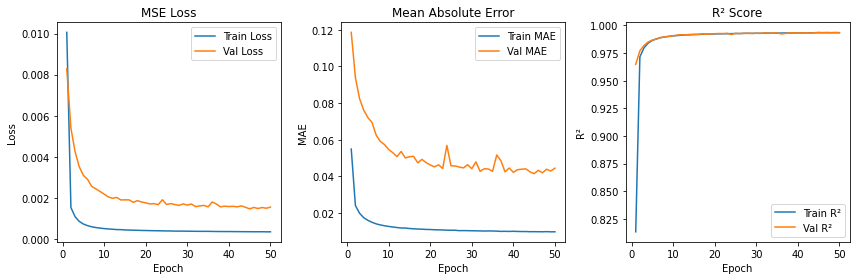

In [11]:
'''
fig, ax = plt.subplot(1,2)
ax[0].plot(epochList,trainLossList,label="Train Loss")
ax[0].plot(epochList,valLossList,label="Val Loss")
plt.legend()
plt.show()
'''

epochs = range(1, numEpochs + 1)

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, trainLosses, label='Train Loss')
plt.plot(epochs, valLosses, label='Val Loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, trainMaes, label='Train MAE')
plt.plot(epochs, valMaes, label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot R² Score
plt.subplot(1, 3, 3)
plt.plot(epochs, trainR2s, label='Train R²')
plt.plot(epochs, valR2s, label='Val R²')
plt.title('R² Score')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()


# Saving the model

In [51]:
#torch.save(model.state_dict(), "05NormClassLSTM.pt")
model.load_state_dict(torch.load(r"C:\Users\jonas\Documents\GitHub\P8\Code\NormNoClassLSTM.pt"))

C:\Users\jonas\AppData\Local\Temp\ipykernel_2340\3542068183.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\jonas\Documents\G

<All keys matched successfully>

# 5 Testing the model

[0.0, 0.005001, 0.010001999999999999, 0.014003, 0.019004, 0.023004000000000004, 0.028006000000000003, 0.033007, 0.037008, 0.041009000000000004, 0.04601, 0.051011, 0.055012000000000005, 0.060013, 0.064014, 0.06901600000000001, 0.073016, 0.077018, 0.08201800000000001, 0.086019, 0.09102, 0.095022, 0.100022, 0.105023, 0.109024, 0.114025, 0.118026, 0.12202700000000001, 0.12702799999999997, 0.13102899999999998, 0.13503099999999998, 0.140031, 0.144032, 0.149034, 0.15403399999999998, 0.15803499999999998, 0.163036, 0.167038, 0.172038, 0.176039, 0.18103999999999998, 0.18504099999999998, 0.190042, 0.194043, 0.199045, 0.20304499999999998, 0.20704599999999998, 0.21204699999999999, 0.217049, 0.221049, 0.22505, 0.23005199999999998, 0.23405199999999998, 0.238053, 0.24305399999999996, 0.24705599999999997, 0.252056, 0.257058, 0.261058, 0.265059, 0.270061, 0.274061, 0.279063, 0.283063, 0.288065, 0.294066, 0.298067, 0.303068, 0.30706900000000004, 0.31207, 0.316071, 0.321072, 0.325073, 0.32907400000000003,

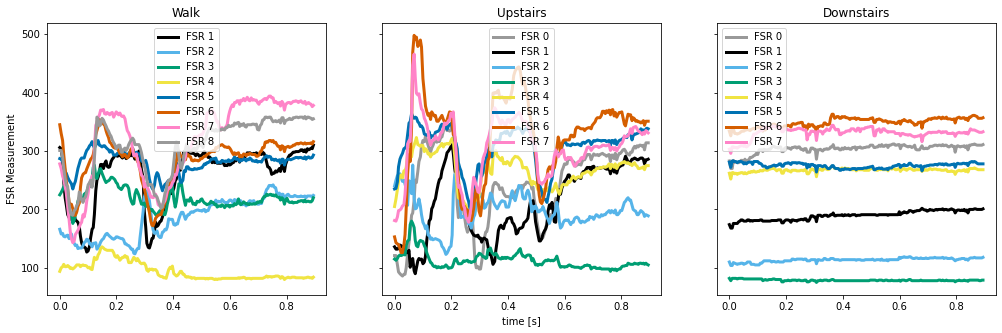

In [52]:
filename1 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Frederik walk.txt"
filename2 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Frederik upstairs.txt"
filename3 = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Frederik downstairs.txt"

dfWalk = grabDataThigh(filename1)
dataWalk = fixTimeData(dfWalk)
dataWalk.pop('type')
dataWalk["Class"] = list(0 for i in range(len(dataWalk["time"])))

dfUp = grabDataThigh(filename2)
dataUp = fixTimeData(dfUp)
dataUp.pop('type')
dataUp["Class"] = list(1 for i in range(len(dataUp["time"])))

dfDown = grabDataThigh(filename3)
dataDown = fixTimeData(dfDown)
dataDown.pop('type')
dataDown["Class"] = list(-1 for i in range(len(dataDown["time"])))

dataTest = [dataWalk,dataUp,dataDown]
for i in dataTest:
    checkDictForStr(i)

plot3FSRComparisons(dataTest)

dataTest = dictExtension(dataTest)

dataTest = fixData(dataTest,normalize,Time,True,Grav,Gyro,Quat,LiAcc,Classification)
dataTest = processFSR(dataTest, FSR, FSRsum, FSRavg)
inputSizeTest = len(dataTest)
sequenceTest = prepareSingleSequenceInput(dataTest)
'''
if normalized:
    targetMean = sequenceTest.mean(dim=0)
    targetStd = sequenceTest.std(dim=0)
    normalizedSequenceTest = (sequenceTest - targetMean) / targetStd
    datasetTest = SequenceDataset(normalizedSequenceTest,250)
else:'''

datasetTest = SequenceDataset(sequenceTest,250)

DataLoaderTest = DataLoader(datasetTest,batch_size=32)

In [53]:
def test(model, testLoader, lossFn, device):
    model.eval()  # Set the model to evaluation mode
    testLoss = 0
    testMaeTotal = 0
    yTestTrue = []
    yTestPred = []
    i = False
    scalingFactor = 1
    totalRMSE = 0
    all_targets = []
    all_predictions = []
    tmptime = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in testLoader:
            batchX, batchY = batch
            batchX, batchY = batchX.to(device), batchY.to(device)
            
            batchX = batchX.float()
            batchX = batchX.squeeze(2)
            batchY = batchY.float()
            batchY = batchY.squeeze(1)
            batchX = torch.nan_to_num(batchX, nan=0.0)
            batchY = torch.nan_to_num(batchY, nan=0.0)

            # Forward pass
            start = time.time()
            outputs = model(batchX)
            '''
            if i:
                pred = outputs[0].squeeze(0).squeeze(0).cpu().numpy()
                scalingFactor = batchY[0].squeeze(0).squeeze(0).cpu().numpy()/pred
                i = False
            '''
            outputs = outputs*scalingFactor
            tmptime = tmptime + (time.time()-start)
            # Compute loss
            loss = lossFn(outputs, batchY)
            testLoss += loss.item()
            
            # Compute MAE
            testMaeTotal += F.l1_loss(outputs, batchY).item()
            totalRMSE += loss.item()**0.5

            # Collect true and predicted values for R²
            yTestTrue.append(batchY.cpu())
            yTestPred.append(outputs.cpu())
            all_targets.append(batchY.detach().cpu())
            all_predictions.append(outputs.detach().cpu())

    # Calculate average test loss and MAE
    avgTestLoss = testLoss / len(testLoader)
    avgTestMae = testMaeTotal / len(testLoader)
    avgRMSE = totalRMSE / len(testLoader)
    avgTime = tmptime / len(testLoader)
    

    # Flatten the predictions and batchY to calculate R²
    yTestTrue = torch.cat(yTestTrue).numpy().flatten()
    yTestPred = torch.cat(yTestPred).numpy().flatten()
    testR2 = r2_score(yTestTrue, yTestPred)

    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    print(f"Test MSE: {avgTestLoss:.4f}, Test RMSE: {avgRMSE:.4f}, Test MAE: {avgTestMae:.4f}, Test R²: {testR2:.4f}, avg Time: {avgTime:.4f}")

    return avgTestLoss, avgTestMae, testR2, all_targets, all_predictions, avgTime

#avgTestLoss, avgTestMae, testR2 = test(model,DataLoaderTest,lossFn,"cpu")
avgTestLoss, avgTestMae, testR2, all_targets, all_predictions, time = test(model,testDataloader,lossFn,"cpu")

Test MSE: 0.0043, Test RMSE: 0.0592, Test MAE: 0.0363, Test R²: 0.9281, avg Time: 0.0014


In [54]:

def collectOutputsAndBatchY(model, dataLoader, device):
    model.eval()  # Set model to evaluation mode
    yTrue = []
    yPred = []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in dataLoader:
            batchX, batchY = batch
            batchX, batchY = batchX.to(device), batchY.to(device)

            
            batchX = batchX.float()
            batchX = batchX.squeeze(2)
            batchY = batchY.float()
            batchY = batchY.squeeze(1)
            #batchX = torch.nan_to_num(batchX, nan=0.0)
            #batchY = torch.nan_to_num(batchY, nan=0.0)

            outputs = model(batchX)

            # Collect the true and predicted values
            yTrue.append(batchY.cpu())  # Move to CPU
            yPred.append(outputs.cpu())  # Same for predictions

    # Flatten the list of batches to get all values
    yTrue = torch.cat(yTrue).numpy().flatten()
    yPred = torch.cat(yPred).numpy().flatten()

    return yTrue, yPred

def plotPredictionsVsActuals(yTrue, yPred, numSamples=5):
    """
    Plots the predicted vs actual sensor values for a few samples.
    
    :param yTrue: Actual sensor readings (ground truth)
    :param yPred: Predicted sensor readings
    :param numSamples: Number of samples to plot (default is 5)
    """
    plt.figure(figsize=(12, 6))

    for i in range(numSamples):
        plt.subplot(numSamples, 1, i + 1)  # Create a subplot for each sample
        plt.plot(yTrue[i], label="True Values", color='blue')
        plt.plot(yPred[i], label="Predicted Values", color='red', linestyle='--')
        plt.title(f"Sample {i+1} - Sensor Readings")
        plt.xlabel("Time Step")
        plt.ylabel("Sensor Value")
        plt.legend()

    plt.tight_layout()
    plt.show()

def plotSequenceAccuracy(model, testData, numSamples=100):
    batch = next(iter(testData))
    batchX, batchY = batch
    batchX = batchX.float()
    batchX = batchX.squeeze(2)
    batchY = batchY.float()
    batchY = batchY.squeeze(1)

    r2Scores = []
    MaeList = []
    yPred = []

    inputs = batchX[0][0].unsqueeze(0)
    output = model(inputs)
    print(output)
    #output = output[0]
    yPred.append(output)

    output = output.detach().numpy()
    tmpR2 = r2_score(batchY[0],output)
    for i in range(1,numSamples):
        output = model(output)
        tmpR2 = r2_score(batchY[:i],yPred)
    x = list(i+1 for i in range(numSamples))
    plt.plot(x,r2Scores)
    plt.xlabel("Samples")
    plt.ylabel("r2 score")
    plt.show()
    

# Example usage
yTrue, yPred = collectOutputsAndBatchY(model, testDataloader, "cpu")
plotSequenceAccuracy(model,testDataloader)

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:
import cv2
from PIL import Image
import numpy as np

In [ ]:
# Function to extract frames
def FrameCapture(path):
    frameList = []
    # Path to video file
    vidObj = cv2.VideoCapture(path)
    fps = vidObj.get(cv2.CAP_PROP_FPS)
    print(fps)

    # Used as counter variable
    count = 0

    # checks whether frames were extracted
    success = 1

    while success:

        # vidObj object calls read
        # function extract frames
        success, image = vidObj.read()

        # Saves the frames with frame-count
        frameList.append(image)

        count += 1

    return frameList, fps


In [ ]:

upStairsList, fps = FrameCapture(r"C:\Users\jonas\Downloads\Check frames 27-28.mp4")
#frameList, fps = FrameCapture(r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Asbjørn walk.mp4")
print(len(upStairsList))

29.9146795151276
941


In [ ]:
arr = upStairsList[822]  # or however you get your numpy array

# If the image is in BGR (like from OpenCV), convert to RGB:
if arr.shape[-1] == 3:  # color image
    arr = arr[..., ::-1]  # reverses the last dimension (BGR -> RGB)

pil_image = Image.fromarray(arr)
pil_image.show()

In [ ]:
def SaveFrameListAsVideo(frameList,fps,path:str):
    fpsList = []

    for i in range(0,len(frameList),math.floor(30/fps)):
        fpsList.append(frameList[i])

    size = (1920,1080)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    fps3Video = cv2.VideoWriter(path,fourcc,fps,size)

    for i in range(len(fpsList)):
        fps3Video.write(fpsList[i])

    fps3Video.release()

def SplitFrameListAsVideo(frameList1,frameList2,fps,path):
    fpsList = []
    # 0-15 sec upstairs 18-26 28-33 downstairs


    for i in range(0,len(frameList),30/fps):
        fpsList.append(frameList[i])

    print(fpsList[0].shape)
    frame = fpsList[0]
    size = frame.shape
    size.pop[2]

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    fps3Video = cv2.VideoWriter(path,fourcc,fps,size)

    for i in range(len(fpsList)):
        fps3Video.write(fpsList[i])

    fps3Video.release()

SaveFrameListAsVideo(upStairsList,3,"3FPSSvend.mp4")

In [ ]:
import zipfile
import os
import numpy as np
from PIL import Image

# Assuming `frames` is a list of frames in numpy.ndarray format
frames = upStairsList  # Replace with your actual list of frames (numpy.ndarray)

# Create a directory to store the PNG files temporarily
output_dir = "temp_images"
os.makedirs(output_dir, exist_ok=True)

# Create a zip file
zip_filename = "frames.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for idx, frame in enumerate(frames):
        # Save only every 10th frame (i.e., when idx is divisible by 10)
        if idx % 10 == 0:
            # Convert numpy.ndarray to a PIL Image
            pil_image = Image.fromarray(frame)
            
            # Save the frame as a PNG file
            png_filename = f"{output_dir}/frame_{idx + 1}.png"
            pil_image.save(png_filename, "PNG")
            
            # Add the saved PNG file to the zip folder
            zipf.write(png_filename, os.path.basename(png_filename))

# Optionally, remove the temporary directory and files
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    os.remove(file_path)
os.rmdir(output_dir)

print(f"Every 10th frame saved and zipped to {zip_filename}")

Every 10th frame saved and zipped to frames.zip


# Comparing data

(3919, 21)


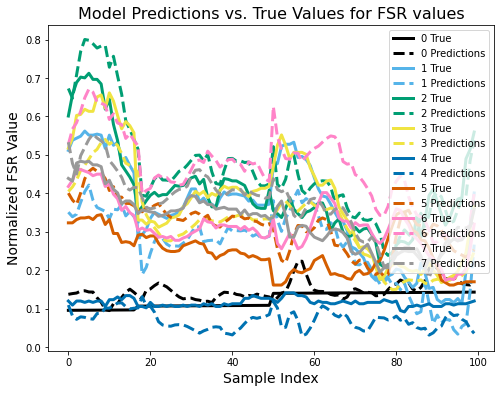

In [59]:
targets_np = all_targets.numpy()
preds_np = all_predictions.numpy()
color_list = [
    "#000000",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion (not pure red)
    "#FF84C8",  # Reddish Purple
    "#999999",  # Grey
]

nameList = [
    "X",
    "Y",
    "Z"
]
#3783:3883
print(targets_np.shape)
feature_idx = 0  # change to select other features
plt.figure(figsize=(8,6))
minRange = 0
for i in range(0,8):
    plt.plot(targets_np[3783:3883, i], label=f"{i} True",linewidth=3,color=color_list[i-minRange])
    plt.plot(preds_np[3783:3883, i], label=f"{i} Predictions",linewidth=3,color=color_list[i-minRange], linestyle='dashed')
plt.legend(loc="upper right")
plt.xlabel("Sample Index",fontsize=14)
plt.ylabel(f"Normalized FSR Value",fontsize=14)
plt.title(f"Model Predictions vs. True Values for FSR values",fontsize=16)
plt.show()

{'feature_0': array([0.06472492, 0.48156452, 0.56750095, ..., 0.4460723 , 0.01361257,
       0.2744681 ], dtype=float32), 'feature_1': array([0.05804749, 0.40538904, 0.40539178, ..., 0.6320379 , 0.4196978 ,
       0.388     ], dtype=float32), 'feature_2': array([0.0297619 , 0.22727273, 0.58477426, ..., 0.50377524, 0.41665065,
       0.23004694], dtype=float32), 'feature_3': array([0.016     , 0.9287599 , 0.2454754 , ..., 0.28305784, 0.5171692 ,
       0.31128076], dtype=float32), 'feature_4': array([0.07773852, 0.84302324, 0.53366584, ..., 0.7519789 , 0.31353557,
       0.03275033], dtype=float32), 'feature_5': array([0.04042553, 0.03236246, 0.49103138, ..., 0.5523256 , 0.5377182 ,
       0.00860966], dtype=float32), 'feature_6': array([0.034     , 0.05013192, 0.40530258, ..., 0.14472508, 0.5435974 ,
       0.41845796], dtype=float32), 'feature_7': array([0.05164319, 0.02380952, 0.23553719, ..., 0.29287598, 0.82060516,
       0.27410218], dtype=float32), 'feature_8': array([0.04709075,

RuntimeError: input.size(-1) must be equal to input_size. Expected 21, got 22

In [ ]:
k = 1
color_list = [
    "#000000",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion (not pure red)
    "#FF84C8",  # Reddish Purple
    "#999999",  # Grey
]


x = [i for i in range(250-1)]
for j in range(len(truthsSorted)):
    fig, ax = plt.subplots(1,1,sharey=True,figsize=(15,7))
    for i in range(8):
        ax.plot(x,truthsSorted[j][i],label=f"True FSR{i}",color=color_list[i],linewidth=3)
        ax.plot(x,predsSorted[j][i],label=f"Predicted FSR{i}",linewidth=3,color=color_list[i], linestyle='dashed')
        ax.set_ylabel('MAE')
        ax.set_title(f'Subject {j+1}')
        ax.legend()
        
    #ax[0].set_xlabel('Prediction Step')
    #ax[1].set_xlabel('Prediction Step')
    
    #fig.set_title('Prediction MAE per Step for Multiple Sequences')
    #ax[0].set_title("Truth")
    #ax[1].set_title("Predicted and scaled")
    plt.show()

NameError: name 'truthsSorted' is not defined